In [98]:
import numpy as np
import pickle
from sklearn import metrics
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import seaborn as sns

from collections import Counter
import seaborn as sns

import os
import pandas as pd
from utils import flatten

from tqdm import tqdm

from ast import literal_eval
from sklearn.metrics import f1_score, precision_score, recall_score


In [2]:
all_cols = [
    'subpillars_1d',
    'subpillars_2d'
    ]

In [92]:
DATA_PATH = os.path.join(
    '..', '..', '..', "data", "frameworks_data", 'data_v0.7.1'
)

tot_df = pd.read_csv(os.path.join(DATA_PATH, 'new_columns_train_val.csv'))[[
    'entry_id', 'excerpt', 'pillars_2d', 'subpillars_2d'
]].drop_duplicates()

for col in ['pillars_2d', 'subpillars_2d']:
    tot_df[col] = tot_df[col].apply(
        lambda x: [item for item in literal_eval(x) if item!='NOT_MAPPED']
    )
    

/home/selim/anaconda3/envs/deepl/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [90]:
number_tags_dict = {
    'At Risk':'At Risk->Number Of People At Risk',
    'Capacities & Response':'Capacities & Response->Number Of People Reached/Response Gaps',
    'Humanitarian Conditions':'Humanitarian Conditions->Number Of People In Need',
    'Impact':'Impact->Number Of People Affected'
}
number_tags_keys = list(number_tags_dict.keys())

In [108]:
def clean_regex(x):
    x = x.replace('(', '')\
            .replace(')', '')\
            .replace('[', '')\
            .replace(']', '')\
            .replace('.', '')\
            .replace(',', '')\
            .replace('%', '')
    return x


def number_present_bool(sentence, min_num_for_keeping):

    split_s = sentence.split(' ')
    nb_numbers_sentence = 0
    for name in split_s:

        name = clean_regex(name)
        if name.isnumeric():
            try:
                #avoid dates
                nb = int(name)
                if nb<1900 or nb>2050:
                    nb_numbers_sentence += 1
            except Exception:
                nb_numbers_sentence += 1
        
    if nb_numbers_sentence > min_num_for_keeping:
        return 1
    else:
        return 0



In [106]:
results_numbers = {}
       
for pillar in tqdm(number_tags_keys):
    pillar_df = tot_df[tot_df.pillars_2d.apply(lambda x: pillar in x)].dropna()
    gt_numbers = pillar_df.subpillars_2d.apply(lambda x: number_tags_dict[pillar] in x).astype(bool).tolist()
    results_precision = []
    results_recall = []
    results_f1 = []
    for max_nb in range (2, 10):
        
        preds_numbers = pillar_df.excerpt.apply(lambda x: number_present_bool(x, max_nb)).tolist()

        results_precision.append(precision_score(gt_numbers, preds_numbers, average='macro'))
        results_recall.append(recall_score(gt_numbers, preds_numbers, average='macro'))
        results_f1.append(f1_score(gt_numbers, preds_numbers, average='macro'))

    results_tmp = {
        'precision': results_precision,
        'f1_score': results_f1,
        'recall': results_recall
    }
    results_numbers[number_tags_dict[pillar]] = results_tmp


100%|██████████| 4/4 [03:35<00:00, 53.79s/it]


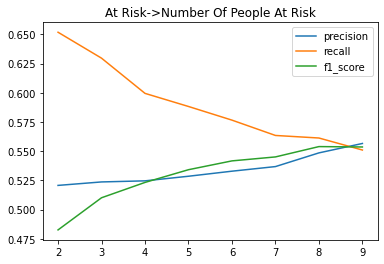

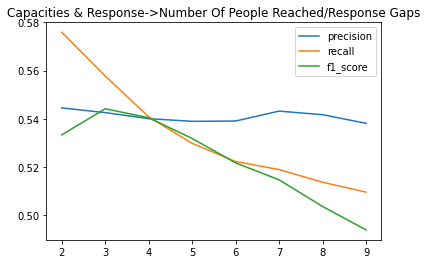

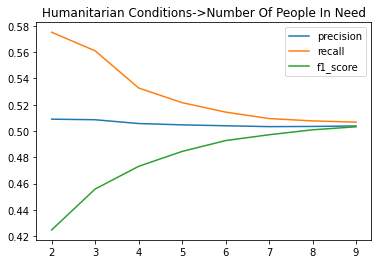

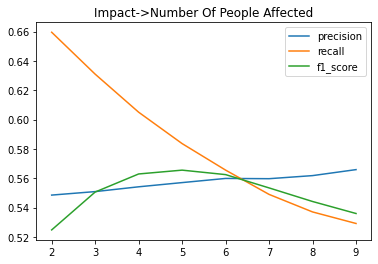

In [107]:
x = [i for i in range (2, 10)]
for pillar in number_tags_keys:
    results = results_numbers[number_tags_dict[pillar]]
    plt.plot(x, results['precision'], label='precision')
    plt.legend()
    plt.plot(x, results['recall'], label='recall')
    plt.legend()
    plt.plot(x, results['f1_score'], label='f1_score')
    plt.legend()
    plt.title(number_tags_dict[pillar])
    plt.show()